<a href="https://colab.research.google.com/github/imjmjmim/Indicator_Analysis/blob/main/202447008_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.90
F1 Score: 0.91
ROC AUC Score: 0.96


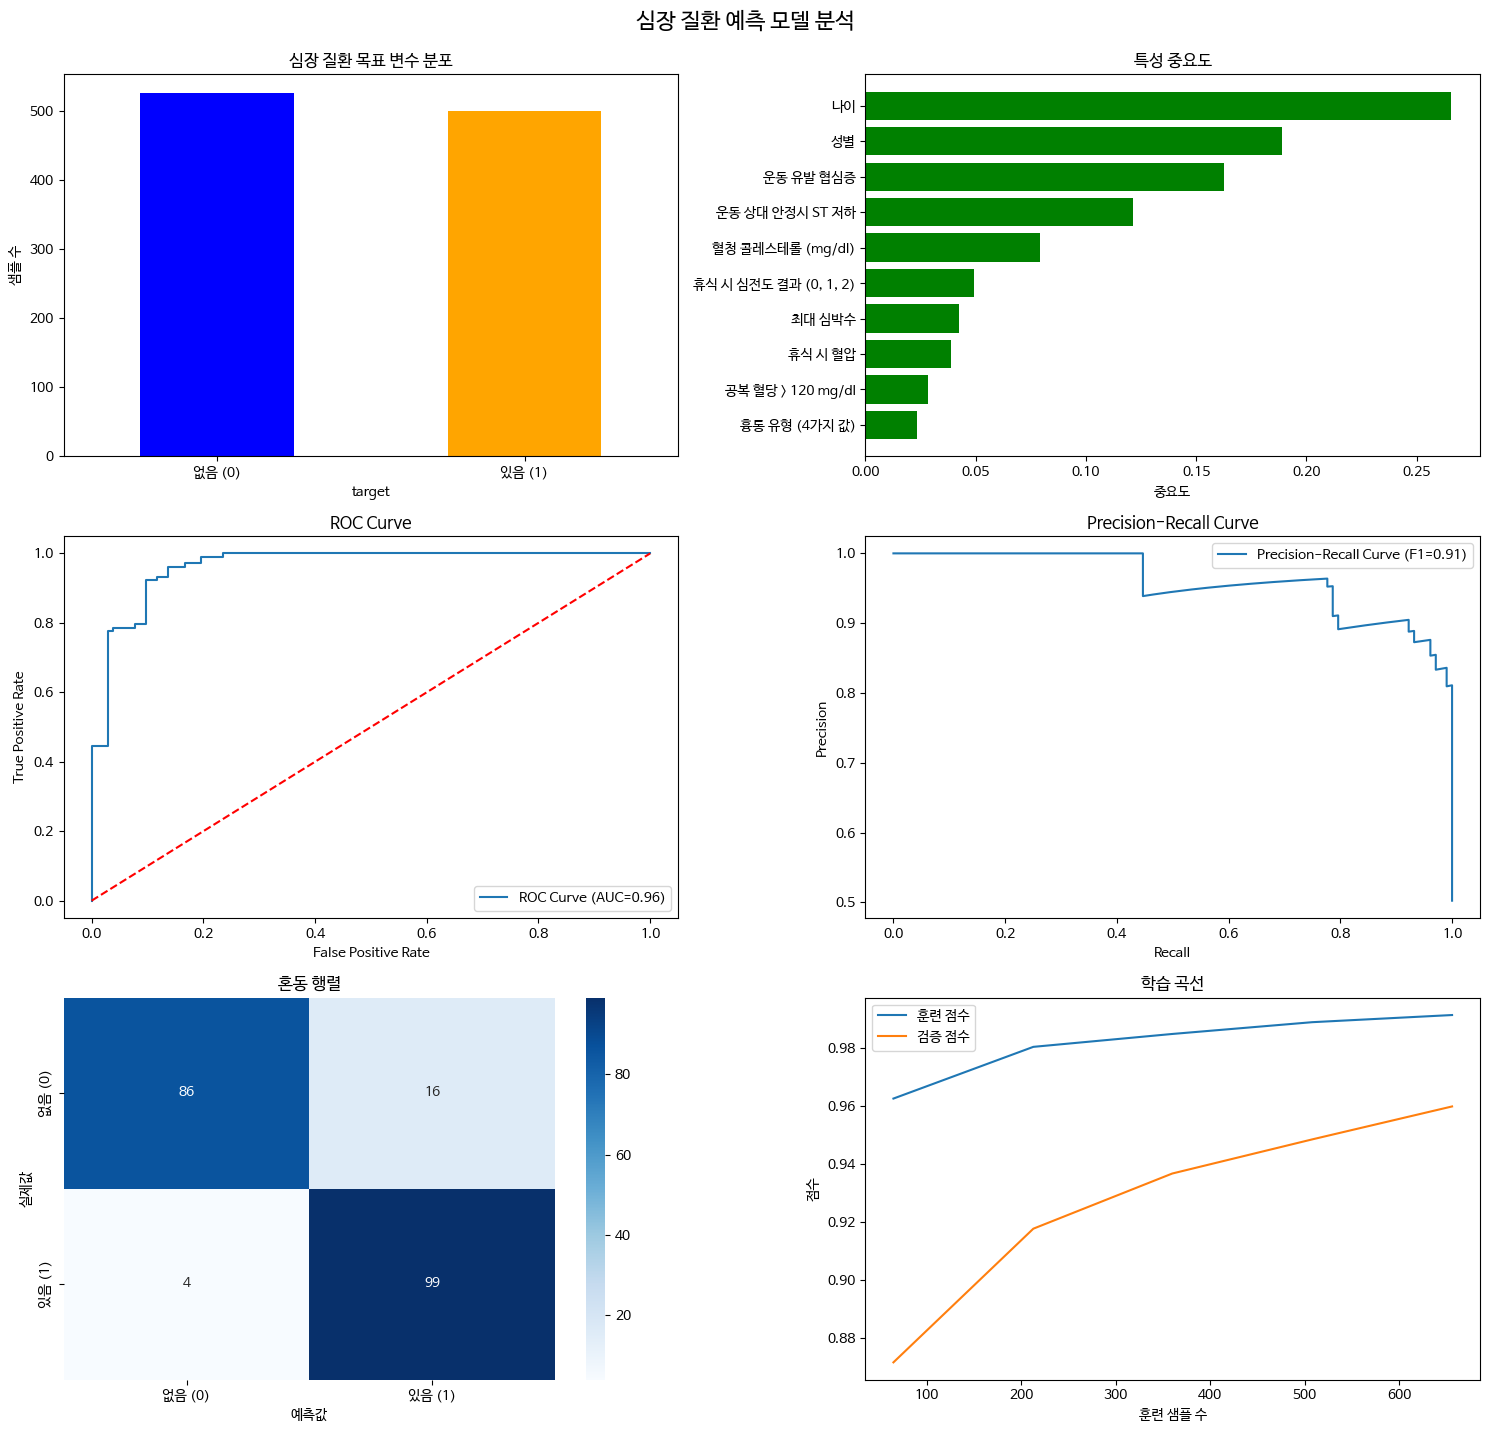

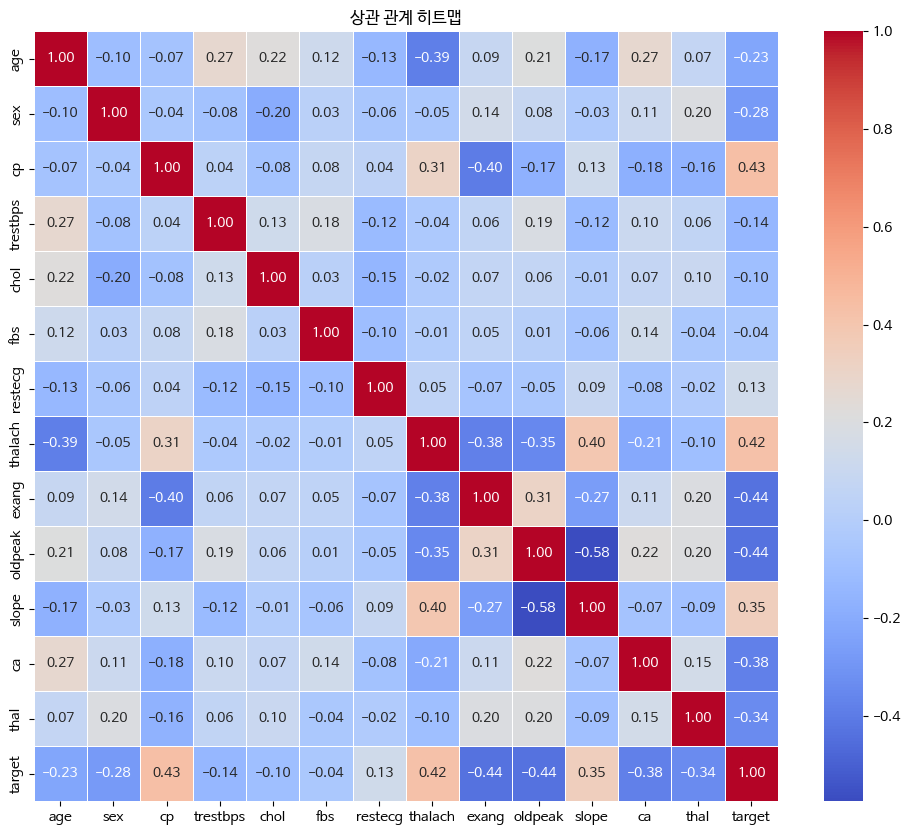

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message=".*unknown categories.*")


def preprocess_data(df):
    df = df.fillna(df.mean())

    numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

    return df, numeric_features, categorical_features

def create_preprocessing_pipeline(numeric_features, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ])

    return preprocessor

def feature_engineering(preprocessor, X, y):
    selector = SelectKBest(score_func=f_classif, k=10)
    return preprocessor, selector

def train_and_evaluate_model(X, y, preprocessor, selector):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [200], #[50,100,150,200,250]
        'classifier__max_depth': [15], #[5,10,15]
        'classifier__min_samples_split': [5], #[5,10,15]
        'classifier__min_samples_leaf': [3] #[3,5,7]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return best_model, accuracy, f1, roc_auc, grid_search.best_params_, X_train, X_test, y_train, y_test, y_pred, y_prob

def visualize_classification_results(df, pipeline, X_train, X_test, y_train, y_test, y_pred, y_prob, model):
    feature_descriptions = {
        'age': '나이',
        'sex': '성별',
        'cp': '흉통 유형 (4가지 값)',
        'trestbps': '휴식 시 혈압',
        'chol': '혈청 콜레스테롤 (mg/dl)',
        'fbs': '공복 혈당 > 120 mg/dl',
        'restecg': '휴식 시 심전도 결과 (0, 1, 2)',
        'thalach': '최대 심박수',
        'exang': '운동 유발 협심증',
        'oldpeak': '운동 상대 안정시 ST 저하',
        'slope': '최대 운동 ST 세그먼트의 경사도',
        'ca': '형광투시법에 의해 색칠된 주요 혈관 수 (0-3)',
        'thal': '탈 (0=정상, 1=고정 결함, 2=가역적 결함)'
    }

    plt.figure(figsize=(15, 14))

    plt.subplot(3, 2, 1)
    df['target'].value_counts().plot(kind='bar', color=['blue', 'orange'])
    plt.title('심장 질환 목표 변수 분포')
    plt.xticks([0, 1], ['없음 (0)', '있음 (1)'])
    plt.xticks(rotation=0)
    plt.ylabel('샘플 수')

    plt.subplot(3, 2, 2)
    feature_importance = model.named_steps['classifier'].feature_importances_
    feature_names = X_train.columns
    feature_importance_sorted_idx = np.argsort(feature_importance)

    feature_names_sorted = [feature_descriptions.get(feature, feature) for feature in feature_names[feature_importance_sorted_idx]]

    plt.barh(feature_names_sorted, feature_importance[feature_importance_sorted_idx], color='green')
    plt.title('특성 중요도')
    plt.xlabel('중요도')

    plt.subplot(3, 2, 3)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(3, 2, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'Precision-Recall Curve (F1={f1_score(y_test, y_pred):.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.subplot(3, 2, 5)
    pipeline.fit(X_train, y_train)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['없음 (0)', '있음 (1)'], yticklabels=['없음 (0)', '있음 (1)'])
    plt.title('혼동 행렬')
    plt.xlabel('예측값')
    plt.ylabel('실제값')

    plt.subplot(3, 2, 6)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc')
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='훈련 점수')
    plt.plot(train_sizes, test_mean, label='검증 점수')
    plt.xlabel('훈련 샘플 수')
    plt.ylabel('점수')
    plt.title('학습 곡선')
    plt.legend()

    plt.tight_layout()
    plt.suptitle('심장 질환 예측 모델 분석', fontsize=16, y=1.02)
    plt.show()

    # 상관 관계 히트맵
    corr_matrix = df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('상관 관계 히트맵')
    plt.show()


def main():
    df = pd.read_csv('heart.csv')

    processed_df, numeric_features, categorical_features = preprocess_data(df)

    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

    X = processed_df.drop('target', axis=1)
    y = processed_df['target']
    preprocessor, selector = feature_engineering(preprocessor, X, y)

    best_model, accuracy, f1, roc_auc, best_params, X_train, X_test, y_train, y_test, y_pred, y_prob = train_and_evaluate_model(
        X, y, preprocessor, selector
    )

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")

    visualize_classification_results(df, best_model, X_train, X_test, y_train, y_test, y_pred, y_prob, best_model)

if __name__ == '__main__':
    main()


#최적 하이퍼파라미터: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

In [ ]:
# matplot 한글 적용시키기 위한 부분
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (23.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123630 files and direc